# Analog Clock Image Trainer

I used the Clock Image Reading dataset available on Kaggle. This dataset contains the data of 2000 images of Analog Clocks in the form of .npy files. <br/>
Link to the DataSet -> https://www.kaggle.com/codingcat99/clock-image-reading

# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import random

Using TensorFlow backend.


# Loading Data

In [2]:
data = np.load("clock_data.npy")
labels = np.load("clock_labels.npy")

# Exploratory Analysis

In [3]:
print(data.shape)
print(labels.shape)

(2000, 64, 64)
(2000, 2)


This shows that the dataset contains 2000 images of <b>64 x 64</b> and corresponding lables are in the form of an 1D array of length 2. Let's plot image to see how they look and what the corresponding labels are.

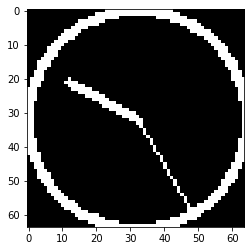

[8. 5.]


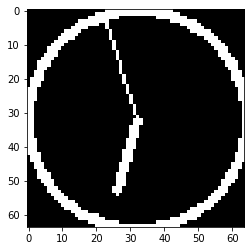

[11. 33.]


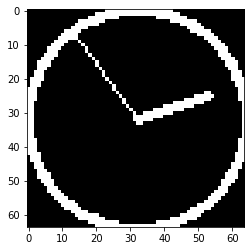

[ 3. 36.]


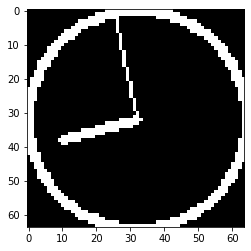

[ 9. 32.]


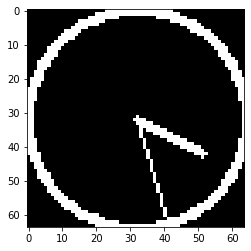

[2. 3.]


In [4]:
for i in range(5):
    plt.imshow(data[i], cmap="gray")
    plt.show()
    print(labels[i])

After plotting images, it can be observed that images and labels do not match. On further analysis I realized that the images are actually flipped around the horizontal axis. This is some fault with the dataset. Let's alter the data so that it is appropriate with the labels. Also, I am seperating the hours and minutes array because that will help better with further analysis.

In [5]:
data = np.asarray([np.flip(a,axis=0) for a in data])

#Seperating hrs and mins
labels.shape = (4000, 1)
hours_label = labels[::2].astype(int)
minutes_label = labels[1::2].astype(int)

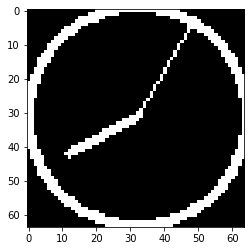

[8]:[5]


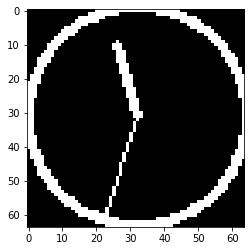

[11]:[33]


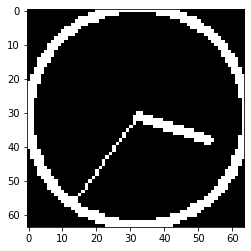

[3]:[36]


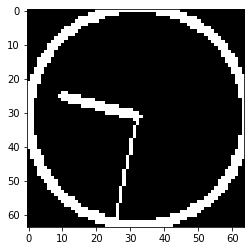

[9]:[32]


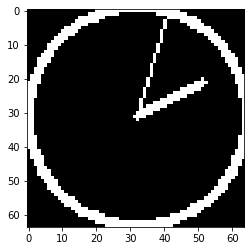

[2]:[3]


In [6]:
for i in range(5):
    plt.imshow(data[i], cmap="gray")
    plt.show()
    print(str(hours_label[i]) + ":" + str(minutes_label[i]))

In [7]:
print("Range of hours is: " + str(min(hours_label)) + " to " + str(max(hours_label)))
print("Range of minutes is: " + str(min(minutes_label)) + " to " + str(max(minutes_label)))

Range of hours is: [0] to [11]
Range of minutes is: [0] to [59]


Now, the images match their labels. It's time to split the data into training and validation sets and then create our model.

# Train-Test Split

I am splitting the data in 80:20 ratio.

In [64]:
categorical_labels_hours = to_categorical(hours_label, num_classes=12)

train_data = data[:int(0.8*len(data))]
h_train = categorical_labels_hours[:int(0.8*len(data))]
m_train = minutes_label[:int(0.8*len(data))]

val_data = data[int(0.8*len(data)):]
h_val = categorical_labels_hours[int(0.8*len(data)):]
m_val = minutes_label[int(0.8*len(data)):]

In [9]:
print(train_data.shape)
print(val_data.shape)
print()
print(h_train.shape)
print(h_val.shape)
print()
print(m_train.shape)
print(m_val.shape)

(1600, 64, 64)
(400, 64, 64)

(1600, 12)
(400, 12)

(1600, 1)
(400, 1)


# Model

Since <b>hour</b> ranges from [0-11], predicting it can be treated as a <b>classification</b> problem with 12 classes but minutes range from [0-59] and it is not feasible to consider 60 classes. So it makes much more sense considering predicting <b> minutes</b> as a <b>regression</b> problem.

The model considered for solving this problem has 4 layers of Convolution and Pooling for feature extraction and then we Flatten the features and use them for Classification and Regression simultaneously.

A rough outline of the models can be:

![Model](./model.png)

In [10]:
inp = tf.keras.Input(shape=(64,64,1))

layer = tf.keras.layers.Conv2D(50, 5, activation='relu')(inp)
layer = tf.keras.layers.MaxPooling2D(2, 2)(layer)

layer = tf.keras.layers.Conv2D(100, 5, activation='relu')(layer)
layer = tf.keras.layers.MaxPooling2D(2, 2)(layer)

layer = tf.keras.layers.Conv2D(150, (3,3), activation='relu')(layer)
layer = tf.keras.layers.MaxPooling2D(2, 2)(layer)

layer = tf.keras.layers.Conv2D(200, (3,3), activation='relu')(layer)
layer = tf.keras.layers.MaxPooling2D(2, 2)(layer)

layer = tf.keras.layers.Flatten()(layer)

layer1 = tf.keras.layers.Dense(144, activation='relu')(layer)

layer2 = tf.keras.layers.Dense(256, activation='relu')(layer)

hour = tf.keras.layers.Dense(12, activation='softmax', name="hour")(layer1)
minutes = tf.keras.layers.Dense(1, activation='linear',name= "minutes")(layer2)

model = tf.keras.Model(inputs= inp, outputs=[hour,minutes])    

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 50)   1300        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 50)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 100)  125100      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [61]:
adam = tf.keras.optimizers.Adam(lr=.01)
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=adam)

history = model.fit(train_data, [h_train,m_train], epochs=50, verbose= 2, validation_data=(val_data, [h_val, m_val]))

model.save("clock_model_50_epoch.h5")

Epoch 1/50
50/50 - 23s - loss: 11.1772 - hour_loss: 0.8797 - minutes_loss: 10.2975 - val_loss: 2.1739 - val_hour_loss: 0.6843 - val_minutes_loss: 1.4895
Epoch 2/50
50/50 - 23s - loss: 1.5116 - hour_loss: 0.6137 - minutes_loss: 0.8979 - val_loss: 1.9340 - val_hour_loss: 0.7387 - val_minutes_loss: 1.1953
Epoch 3/50
50/50 - 23s - loss: 0.7878 - hour_loss: 0.5008 - minutes_loss: 0.2870 - val_loss: 1.1848 - val_hour_loss: 0.6880 - val_minutes_loss: 0.4968
Epoch 4/50
50/50 - 23s - loss: 0.6328 - hour_loss: 0.4729 - minutes_loss: 0.1598 - val_loss: 1.2834 - val_hour_loss: 0.7456 - val_minutes_loss: 0.5378
Epoch 5/50
50/50 - 23s - loss: 0.6709 - hour_loss: 0.4686 - minutes_loss: 0.2023 - val_loss: 1.1235 - val_hour_loss: 0.6155 - val_minutes_loss: 0.5080
Epoch 6/50
50/50 - 23s - loss: 0.7258 - hour_loss: 0.4795 - minutes_loss: 0.2463 - val_loss: 1.4095 - val_hour_loss: 0.8098 - val_minutes_loss: 0.5997
Epoch 7/50
50/50 - 24s - loss: 0.8039 - hour_loss: 0.4544 - minutes_loss: 0.3495 - val_loss:

# Plotting Insights

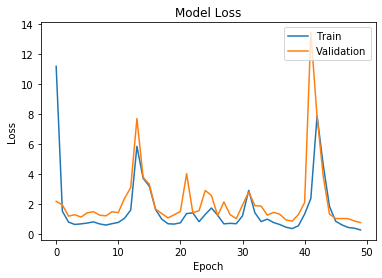

In [75]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()